In [23]:
# 导入库函数
import numpy as np
import cv2
import os
import numpy as np
import scipy
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt


In [24]:
Pi = 3.14159265358979323846

def knn_graph(Data, method, k):
    """
    计算k近邻图

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - k: 最近邻的数量

    Returns:
    - knn_adjacency_matrix: k近邻图的邻接矩阵，W[i, j]表示样本点i和j之间是否相连
    """
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data, distances): 
    n = Data.shape[0] # 数据集的大小
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

# 计算k最近邻索引矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_avg_radius(Data, distances)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            distances = np.sqrt(np.sum((Data[i] - Data) ** 2, axis=1))
            neighbors = []
            for j in range(n):  # 初始化 neighbors 列表
                if (distances[j] <= radius[i]) and (len(neighbors) <= n/2): # 如果样本点 j 在第i个样本点的epsilon邻域内
                    neighbors.append(j)
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, k, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    if method == 'knn':
        # 计算相似度矩阵
        similarity_matrix = np.exp(-distances ** 2 / t)
        # 将相似度矩阵按照邻接矩阵进行筛选，得到需要设置权重的位置
        i_indices, j_indices = np.where(adjacency_matrix == 1)
        # 设置权重
        Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
        Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]  # 对称矩阵
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if adjacency_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / t) # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / t) # 邻接矩阵为对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    print('adjacency_matrix:', adjacency_matrix.shape)
    print('Weight_matrix:', Weight_matrix.shape)
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix  
    

In [25]:
# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    num_classes = len(np.unique(train_labels))  # 类别数量
    num_samples_per_class = train_data.shape[0] // num_classes  # 每个类别的样本数
    num_features = train_data.shape[1]  # 每个样本的特征维度
    
    means = np.zeros((num_classes, num_features))  # 存储每个类别的均值矩阵
    
    for i in range(1, num_classes + 1):  # 遍历每个类别
        temp_indices = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.sum(train_data[temp_indices], axis=0)  # 计算当前类别的特征值总和
        means[i-1] = temp_sum / num_samples_per_class  # 计算当前类别的均值
        
    return means  # 返回每个类别的均值矩阵

# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值
    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）

# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引
        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵
        
    return Z  # 返回中心类别矩阵

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    Sw = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return Sw  # 返回类内散布矩阵

In [26]:
def ShowEigenface(eigenfaces,faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    print("显示特征脸")
    plt.show()

In [27]:
def LPP(Data, faceshape, d, k, t):
    """
    进行LPP算法，得到特征映射后的数据集

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - d: 降维后的维度
    - k: 最近邻的数量
    - t: 高斯核函数的参数

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    - selected_eigenvalues: 特征值
    """
    Data = Data.T
    # Step 1: 计算权重矩阵
    Weight_matrix = construct_weight_matrix(Data, "knn", k, t)
    print("权重矩阵形状：", Weight_matrix.shape)

    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    print("度矩阵形状：", Degree_matrix.shape)
    Laplacian_matrix = Degree_matrix - Weight_matrix
    print("拉普拉斯矩阵形状：", Laplacian_matrix.shape)

    # Step 3: 进行特征映射
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    selected_eigenvalues = eigenvalues.real[selected_indices]
    print("LPP特征脸形状：", selected_eigenvectors.shape)
    ShowEigenface(selected_eigenvectors, faceshape)
    return selected_eigenvectors, Laplacian_matrix

In [28]:
def MLDA(train_data, train_labels, faceshape, d):
    """
    使用多元线性判别分析（MLDA）进行特征提取。

    Args:
    - train_data: 训练数据集的特征矩阵
    - train_labels: 训练数据集的标签
    - d: 要提取的特征数量

    Returns:
    - selected_eigenvectors: 特征映射后的数据集
    - selected_eigenvalues: 特征值
    """
    # 计算每个类别的均值矩阵
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    print('classes_means形状：', classes_means.shape)

    # 计算所有类别的整体均值矩阵
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('overall_mean形状：', overall_mean.shape)

    # 计算中心类别矩阵
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)
    print('Z形状：', Z.shape)

    # 计算类间散布矩阵
    Sb = compute_between_class_scatter_matrix(classes_means, overall_mean)
    print('Sb形状：', Sb.shape)

    # 计算类内散布矩阵
    Sw = compute_class_scatter_matrix(Z)
    print('Sw形状：', Sw.shape)

    W_value = np.dot(np.linalg.inv(Sw), Sb)  # 计算投影矩阵W
    print(W_value.shape)  # 输出投影矩阵W的形状

    # 计算广义特征值问题的特征值和特征向量，提取前d个最大特征值对应的特征向量
    eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((faceshape[0] * faceshape[1]-d),(faceshape[0] * faceshape[1]-1)))  # 计算特征值和特征向量
    print('Done LDA selected eigenvectors computing')  # 输出提示信息
    print('LDA特征脸形状：', eigen_vectors.shape)
    ShowEigenface(eigen_vectors, faceshape)
    return eigen_vectors, Sb, Sw

In [29]:
def MLDA_LPP(train_data, train_labels, faceshape, d, k, t):
    # Step 1: 使用LDA进行特征提取
    eigen_vectors, Sb, Sw = MLDA(train_data, train_labels, faceshape, d)
    # Step 2: 使用LPP进行特征提取
    selected_eigenvectors, Laplacian_matrix = LPP(train_data, faceshape, d, k, t)
    return eigen_vectors, Sb, Sw, selected_eigenvectors, Laplacian_matrix

In [30]:
def read_images(dataset_dir, target_size=(32, 32)):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 缩放图像至目标尺寸
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    train_samples = int(num_samples * train_test_split_ratio)  # 训练集样本数

    # 随机打乱数据集
    indices = np.random.permutation(num_samples)
    data = data[indices]
    labels = labels[indices]
    
    # 划分训练集和测试集
    train_data = data[:train_samples]
    train_labels = labels[:train_samples]
    test_data = data[train_samples:]
    test_labels = labels[train_samples:]
    
    return train_data, train_labels, test_data, test_labels


faceshape: (32, 32)
classes_means形状： (40, 1024)
overall_mean形状： (1024, 1)
Z形状： (200, 1024)


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_9720\2386802214.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引


Sb形状： (1024, 1024)
Sw形状： (1024, 1024)
(1024, 1024)


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_9720\855354853.py:38: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  eigen_values, eigen_vectors = scipy.linalg.eigh(W_value, eigvals=((faceshape[0] * faceshape[1]-d),(faceshape[0] * faceshape[1]-1)))  # 计算特征值和特征向量


Done LDA selected eigenvectors computing
LDA特征脸形状： (1024, 70)
显示特征脸


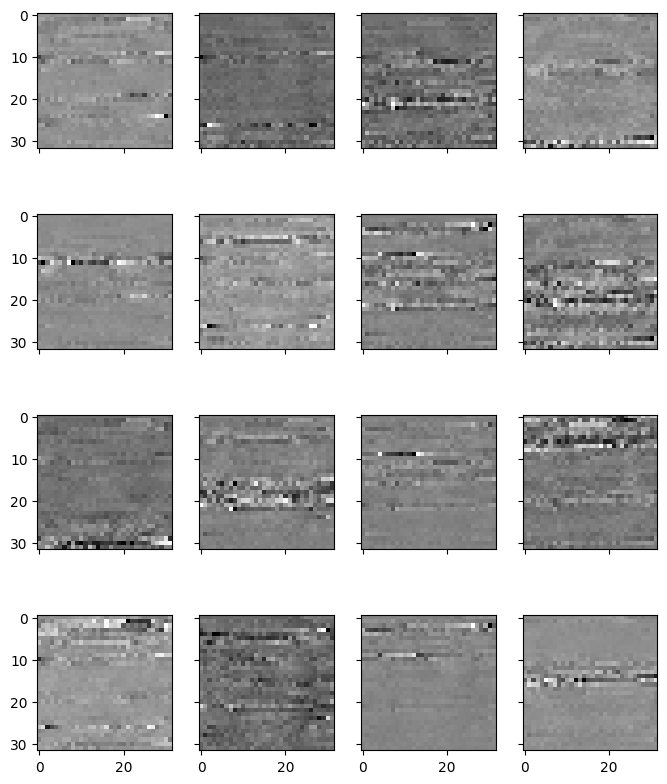

adjacency_matrix: (1024, 1024)
Weight_matrix: (1024, 1024)
权重矩阵形状： (1024, 1024)
度矩阵形状： (1024, 1024)
拉普拉斯矩阵形状： (1024, 1024)
LPP特征脸形状： (1024, 70)
显示特征脸


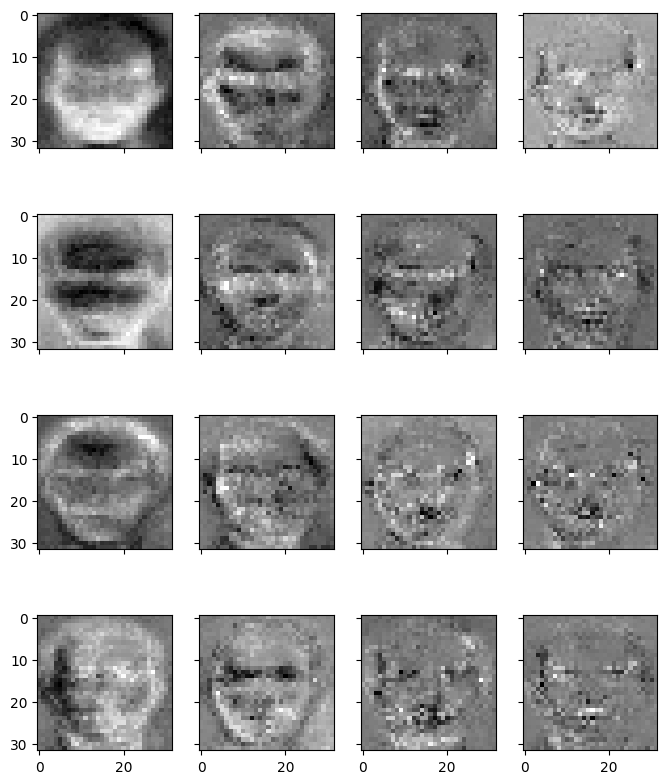

In [31]:
dataset = "attfaces"
data, labels, faceshape = read_images(dataset)
print('faceshape:', faceshape)
train_data, train_labels, test_data, test_labels = train_test_split(data, labels, train_test_split_ratio=0.5)
d = 70
n_neighbors = 300
t = 500000
eigen_vectors, Sb, Sw, selected_eigenvectors, Laplacian_matrix = MLDA_LPP(train_data, train_labels, faceshape, d, n_neighbors, t)

In [32]:
def DLPP(Data, dimension, Laplacian_matrix, Sb, Sw): 
    # Step 1: 组合LPP和LDA的信息，构建目标函数的分子和分母
    numerator = np.dot(np.dot(Data, Laplacian_matrix), Data.T)
    denominator = np.dot(np.dot(Data, Sw - Sb), Data.T)
    
    # Step 2: 分式
    objective_value = numerator / denominator

    # Step 3: 求解广义特征值问题的特征值和特征向量
    eigenvalues, eigenvectors = eigs(objective_value, k=dimension+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:dimension + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    return selected_eigenvectors


DLPP目标函数形状： (1024, 70)
显示特征脸


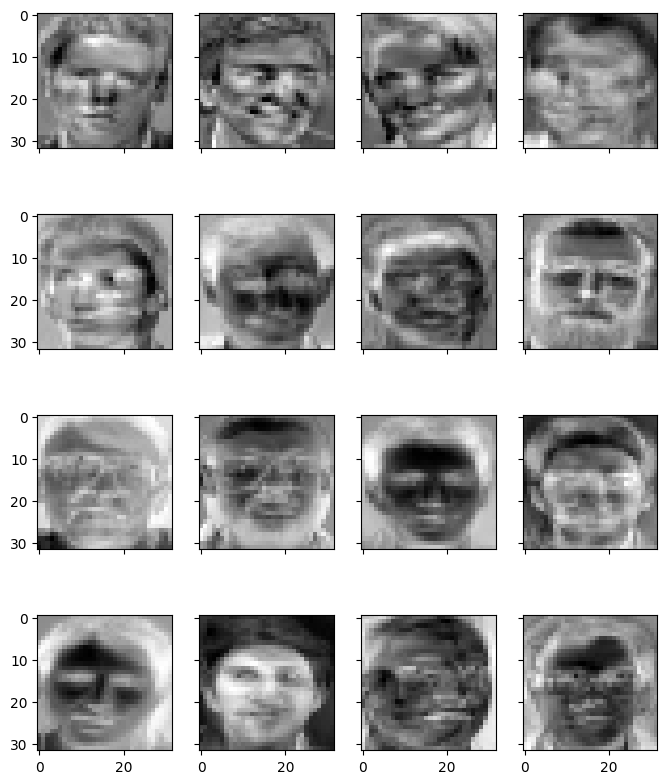

In [33]:
dlpp_eigenvectors= DLPP(train_data, d, Laplacian_matrix, Sb, Sw)
dlpp_imbedding = np.dot(train_data.T, dlpp_eigenvectors)
print("DLPP目标函数形状：", dlpp_imbedding.shape)
ShowEigenface(dlpp_imbedding, faceshape)